In [4]:
import torch
torch.manual_seed(42)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ColoredMNISTModel(nn.Module):
    def __init__(self):
        super(ColoredMNISTModel, self).__init__()
        self.fc1 = nn.Linear(3 * 28 * 28, 256)  # Input layer (3x28x28 pixels for RGB)
        self.fc2 = nn.Linear(256, 128)          # Larger hidden layer
        self.fc3 = nn.Linear(128, 10)           # Output layer (10 classes)

        # Initialize a cache to store lists of activations
        self.activation_cache = {
            'fc1': [],
            'fc2': [],
            'fc3': []
        }

    def forward(self, x, cache_activations=True):
        x = x.view(-1, 3 * 28 * 28)  # Flatten the input image (accounting for 3 channels)
        
        # Pass through fc1 and cache activations if needed
        fc1_out = torch.relu(self.fc1(x))
        if cache_activations:
            self.activation_cache['fc1'].append(fc1_out.detach().clone())
        
        # Pass through fc2 and cache activations if needed
        fc2_out = torch.relu(self.fc2(fc1_out))
        if cache_activations:
            self.activation_cache['fc2'].append(fc2_out.detach().clone())
        
        # Pass through fc3 and cache activations if needed
        fc3_out = self.fc3(fc2_out)
        if cache_activations:
            self.activation_cache['fc3'].append(fc3_out.detach().clone())

        return fc3_out

    def get_cached_activations(self, layer_name):
        return torch.cat(self.activation_cache[layer_name]) if layer_name in self.activation_cache else None

    def clear_cache(self):
        self.activation_cache = {
            'fc1': [],
            'fc2': [],
            'fc3': []
        }

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 5

# Transform MNIST to RGB
class ToRGB:
    def __call__(self, img):
        return img.repeat(3, 1, 1)  # Repeat the grayscale channel 3 times

# Updated transforms for colored MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    ToRGB(),  # Convert to RGB
    transforms.Normalize(mean=[0.1307, 0.1307, 0.1307],  # Same normalization for each channel
                       std=[0.3081, 0.3081, 0.3081])
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function and optimizer
model = ColoredMNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Optional: Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

test_model(model, test_loader)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

In [3]:
torch.save(model.state_dict(), 'models/mnist_colored.pth')

## MNIST

In [7]:
import torch
import torch.nn as nn

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (28x28 pixels)
        self.fc2 = nn.Linear(128, 64)       # Hidden layer
        self.fc3 = nn.Linear(64, 10)        # Output layer (10 classes)

        # Initialize a cache to store lists of activations
        self.activation_cache = {
            'fc1': [],
            'fc2': [],
            'fc3': []
        }

    def forward(self, x, cache_activations=True):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        
        # Pass through fc1 and cache activations if needed
        fc1_out = torch.relu(self.fc1(x))
        if cache_activations:
            self.activation_cache['fc1'].append(fc1_out.detach().clone())  # Append fc1 activations
        
        # Pass through fc2 and cache activations if needed
        fc2_out = torch.relu(self.fc2(fc1_out))
        if cache_activations:
            self.activation_cache['fc2'].append(fc2_out.detach().clone())  # Append fc2 activations
        
        # Pass through fc3 and cache activations if needed
        fc3_out = self.fc3(fc2_out)
        if cache_activations:
            self.activation_cache['fc3'].append(fc3_out.detach().clone())  # Append fc3 activations

        return fc3_out

    # Method to retrieve cached activations for a specified layer
    def get_cached_activations(self, layer_name):
        return torch.cat(self.activation_cache[layer_name]) if layer_name in self.activation_cache else None

    # Method to clear the cache
    def clear_cache(self):
        self.activation_cache = {
            'fc1': [],
            'fc2': [],
            'fc3': []
        }

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters

learning_rate = 0.001
epochs = 5

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std deviation of MNIST dataset
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST_test_dataset = test_dataset #* Test dataset for mnist class 
print(batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function and optimizer
model = MNISTModel()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
all_activations = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero out previous gradients
        outputs = model(images)  # Get output and activations from fc2
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Gradient descent
        total_loss += loss.item()

        # Store activations for the sparse autoencoder

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [9]:
torch.save(model.state_dict(), 'models/mnist_model.pth')

### Test Loop

In [ ]:
#* Test Accuracy Loop 
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {100 * correct / total}%")

### Cache Code

In [25]:
#* Test Accuracy Loop 
model.clear_cache()
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images, cache_activations=True)
        _, predicted = torch.max(outputs.data, 1)

In [26]:
model.get_cached_activations('fc1').shape, model.get_cached_activations('fc2').shape, model.get_cached_activations('fc3').shape

(torch.Size([10000, 256]), torch.Size([10000, 128]), torch.Size([10000, 10]))

In [27]:
test_loader.dataset.data.shape

torch.Size([10000, 28, 28])

### Maximally Activating Image Analysis

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

class AnalysisMNISTModel(nn.Module):
    def __init__(self):
        super(AnalysisMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        fc1_out = torch.relu(self.fc1(x))
        fc2_out = torch.relu(self.fc2(fc1_out))
        fc3_out = self.fc3(fc2_out)
        return fc3_out, fc1_out, fc2_out

def gaussian_blur(img, kernel_size=3, sigma=1.0):
    # Ensure the image has a batch dimension
    if img.dim() == 3:
        img = img.unsqueeze(0)
    
    # Create the Gaussian kernel
    kernel = torch.tensor([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    kernel = kernel / kernel.sum()
    
    # Apply the convolution
    padding = (kernel_size - 1) // 2
    blurred = F.conv2d(img, kernel, padding=padding, groups=img.shape[1])
    
    return blurred.squeeze(0)  # Remove the batch dimension

def activation_maximization(model, layer_index, neuron_index, num_iterations=500, learning_rate=0.1):
    model.eval()
    
    # Create a random input image
    input_image = torch.randn(1, 1, 28, 28, requires_grad=True)
    
    # Define the optimizer
    optimizer = torch.optim.Adam([input_image], lr=learning_rate)
    
    # Define transforms for regularization
    jitter = transforms.Compose([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),
    ])
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Apply jitter transformation
        jittered_image = jitter(input_image)
        
        # Apply custom Gaussian blur
        blurred_image = gaussian_blur(jittered_image, kernel_size=3, sigma=0.5)
        
        # Forward pass
        _, fc1_out, fc2_out = model(blurred_image)
        
        # Get the activation of the specified neuron
        if layer_index == 0:
            target_activation = fc1_out[0, neuron_index]
        elif layer_index == 1:
            target_activation = fc2_out[0, neuron_index]
        else:
            raise ValueError("Invalid layer index")
        
        # Compute the loss (negative activation to maximize it)
        loss = -target_activation
        
        # Add L2 regularization
        l2_reg = 1e-3 * torch.sum(input_image**2)
        loss += l2_reg
        
        # Add total variation regularization
        tv_reg = 1e-4 * (torch.sum(torch.abs(input_image[:,:,:-1] - input_image[:,:,1:])) + 
                         torch.sum(torch.abs(input_image[:,:-1,:] - input_image[:,1:,:])))
        loss += tv_reg
        
        # Backward pass
        loss.backward()
        
        # Update the input image
        optimizer.step()
        
        # Clip the image values to be between 0 and 1
        with torch.no_grad():
            input_image.clamp_(0, 1)
        
        # Periodically apply sharpening
        if i % 50 == 0:
            input_image.data = sharpen(input_image.data)
    
    # Normalize the resulting image
    optimized_image = input_image.squeeze().detach()
    optimized_image = (optimized_image - optimized_image.min()) / (optimized_image.max() - optimized_image.min())
    
    return optimized_image

def sharpen(image):
    """Apply a sharpening filter to the image."""
    blurred = gaussian_blur(image, kernel_size=3, sigma=1.0)
    sharpened = image + (image - blurred) * 0.5
    return torch.clamp(sharpened, 0, 1)

def visualize_neuron_activations(model, layer_index, num_neurons=64):
    rows = int((num_neurons)**0.5)
    cols = (num_neurons + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.ravel()
    
    for i in range(num_neurons):
        optimized_image = activation_maximization(model, layer_index, i)
        axes[i].imshow(optimized_image, cmap='gray')
        axes[i].set_title(f'Neuron {i}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(num_neurons, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'docs/images/MNIST-activation_maximization-layer{layer_index}.png')
    plt.show()

# Assuming you have already trained your model
model = AnalysisMNISTModel()
# Load your trained weights here if necessary
model.load_state_dict(torch.load('models/mnist_model.pth'))

# Example usage
visualize_neuron_activations(model, layer_index=0, num_neurons=64)  # Visualize fc2 layer

## Feature Maps

In [ ]:
def visualize_feature_maps(model, data_loader):
    model.eval()  # Set the model to evaluation mode

    for images, _ in data_loader:
        with torch.no_grad():
            _, fc1_out, fc2_out = model(images)
            
            # Visualize activations of the first image in the batch
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.bar(range(fc1_out.shape[1]), fc1_out[0].numpy())
            plt.title('fc1 Feature Map')
            
            plt.subplot(1, 2, 2)
            plt.bar(range(fc2_out.shape[1]), fc2_out[0].numpy())
            plt.title('fc2 Feature Map')
            plt.show()
        
        break  # Just show for the first batch

# Example usage:
visualize_feature_maps(model, test_loader)

## SAE

*Activations Shapes:* 
- fc1: torch.Size([10000, 128])
- fc2: torch.Size([10000, 64])
- fc3: torch.Size([10000, 10]))


In [4]:
class LayerConfig:
    def __init__(self, name, input_dim):
        self.name = name
        self.input_dim = input_dim

# Create instances for each layer
fc1_config = LayerConfig('fc1', 256)
fc2_config = LayerConfig('fc2', 64)
fc3_config = LayerConfig('fc3', 10)

### Simple SAE

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class SimpleSAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, l1_coeff=0.1, seed=42):
        super(SimpleSAE, self).__init__()
        torch.manual_seed(seed)
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.l1_coeff = l1_coeff  # L1 regularization coefficient for sparsity
        
        # Initialize a cache to store lists of activations
        self.activation_cache = {
            'encoder': [],
            'decoder': []
        }

    def forward(self, x, cache_activations=False):
        # Encoder: Reduce the dimensionality
        encoded = torch.relu(self.encoder(x))
        if cache_activations:
            self.activation_cache['encoder'].append(encoded.detach().clone())  # Append encoder activations

        # Decoder: Reconstruct the original input
        decoded = self.decoder(encoded)
        if cache_activations:
            self.activation_cache['decoder'].append(decoded.detach().clone())  # Append decoder activations

        return encoded, decoded

    def compute_loss(self, x, decoded, encoded):
        # Reconstruction Loss (MSE)
        recon_loss = nn.MSELoss()(decoded, x)

        # L1 Sparsity Loss (L1 regularization on encoded activations)
        l1_loss = self.l1_coeff * torch.sum(torch.abs(encoded))

        # Combine losses: L = MSE + λ * L1
        loss = recon_loss + l1_loss

        return loss

    # Method to retrieve cached activations for a specified layer
    def get_cached_activations(self, layer_name):
        return torch.cat(self.activation_cache[layer_name]) if layer_name in self.activation_cache else None

    # Method to clear the cache
    def clear_cache(self):
        self.activation_cache = {
            'encoder': [],
            'decoder': []
        }

In [5]:
import math 
import torch.nn.functional as F

class EnhancedSAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, l1_coeff=0.1, seed=42):
        super(EnhancedSAE, self).__init__()
        self.l1_coeff = l1_coeff  # L1 regularization coefficient for sparsity
        torch.manual_seed(seed)

        # Encoder and decoder with Kaiming initialization
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.decoder.weight, a=math.sqrt(5))
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()

        self.activation_cache = {
            'encoder': [],
            'decoder': []
        }


    def forward(self, x, cache_activations=True):
        # Center the input
        x_centered = x - self.decoder.bias
        # Encoder: Reduce the dimensionality
        encoded = F.relu(self.encoder(x_centered))
        
        if cache_activations:
            self.activation_cache['encoder'].append(encoded.detach().clone())  # Append encoder activations

        # Decoder: Reconstruct the original input
        decoded = self.decoder(encoded)
        if cache_activations:
            self.activation_cache['decoder'].append(decoded.detach().clone())  # Append decoder activations

        return encoded, decoded

    def compute_loss(self, x, decoded, encoded):
        # Reconstruction Loss (MSE)
        recon_loss = nn.MSELoss()(decoded, x)

        # L1 Sparsity Loss (L1 regularization on encoded activations)
        l1_loss = self.l1_coeff * torch.sum(torch.abs(encoded))

        # Combine losses: L = MSE + λ * L1
        loss = recon_loss + l1_loss

        return loss

    def get_cached_activations(self, layer_name):
        return torch.cat(self.activation_cache[layer_name]) if layer_name in self.activation_cache else None


    def clear_cache(self):
        self.activation_cache = {
            'encoder': [],
            'decoder': []
        }


In [ ]:
# Choose the layer configuration you want to use
selected_layer_config = fc1_config  # Change this to fc2_config or fc3_config as needed

# Use the selected layer configuration
input_dim = selected_layer_config.input_dim
hidden_dim = 2304
sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)

# Optimizer
optimizer_sae = optim.Adam(sae.parameters(), lr=learning_rate)

# Activations loaded from cache
train_activations = model.get_cached_activations(selected_layer_config.name)

# Split the activations into train and test sets (80% train, 20% test)
train_activations, test_activations = train_test_split(train_activations, test_size=0.2, random_state=42)

# DataLoader for activations
train_activations_loader = DataLoader(train_activations, batch_size=batch_size, shuffle=True)
test_activations_loader = DataLoader(test_activations, batch_size=batch_size, shuffle=False)

SAE_test_activations = test_activations #* Test dataset for SAE class

# Training Loop for SAE
epochs = 50  # You can adjust this based on your preference
for epoch in range(epochs):
    sae.train()
    total_loss = 0
    for batch in train_activations_loader:
        optimizer_sae.zero_grad()  # Zero out previous gradients

        # Forward pass through the SAE
        encoded, decoded = sae(batch)

        # Compute loss (MSE + sparsity penalty)
        loss = sae.compute_loss(batch, decoded, encoded)

        loss.backward()  # Backprop for SAE
        optimizer_sae.step()  # Optimizer step

        total_loss += loss.item()

    print(f"SAE Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_activations_loader):.4f}")


In [14]:
# Activations loaded from cache
train_activations = model.get_cached_activations(selected_layer_config.name)

# Split the activations into train and test sets (80% train, 20% test)
train_activations, test_activations = train_test_split(train_activations, test_size=0.2, random_state=42)

# DataLoader for activations
train_activations_loader = DataLoader(train_activations, batch_size=batch_size, shuffle=True)
test_activations_loader = DataLoader(test_activations, batch_size=batch_size, shuffle=False)

In [15]:
# Evaluation Loop for SAE
sae.load_state_dict(torch.load('models/mnist_sae_colored.pth'))
sae.eval()
total_test_loss = 0
with torch.no_grad():
    for batch in test_activations_loader:
        # Forward pass through the SAE
        encoded, decoded = sae(batch)

        # Compute loss (MSE + sparsity penalty)
        loss = sae.compute_loss(batch, decoded, encoded)

        total_test_loss += loss.item()

print(f"SAE Test Loss: {total_test_loss/len(test_activations_loader):.4f}")


/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_73347/1586278045.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load('models/mnist_

SAE Test Loss: 15.6865


In [37]:
torch.save(sae.state_dict(), 'models/mnist_sae_colored.pth')

### Activation Maximization

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

def plot_reconstructions(model, test_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        samples = test_data[:num_samples]
        _, reconstructions = model(samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        axes[0, i].imshow(samples[i].reshape(8,16), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructions[i].reshape(8,16), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

def plot_latent_space(model, test_data):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    encoded = encoded.numpy()
    pca = PCA(n_components=2)
    encoded_2d = pca.fit_transform(encoded)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], alpha=0.5)
    plt.title('2D PCA of Latent Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar()
    plt.show()

def plot_feature_activations(model, test_data, num_features=10):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    feature_activations = encoded.mean(dim=0)
    top_features = torch.argsort(feature_activations, descending=True)[:num_features]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_features), feature_activations[top_features])
    plt.title(f'Top {num_features} Most Active Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Activation')
    plt.show()

def compute_cosine_similarity(model, test_data):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    encoded = encoded.numpy()
    similarity_matrix = cosine_similarity(encoded)
    
    nonzero_indices = np.nonzero(similarity_matrix)
    nonzero_values = similarity_matrix[nonzero_indices]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(nonzero_indices[0], nonzero_indices[1], c=nonzero_values, cmap='viridis')
    plt.colorbar()
    plt.title('Nonzero Cosine Similarity of Encoded Representations')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.show()

def activation_maximization_sae(model, neuron_index, num_iterations=100, learning_rate=0.1):
    model.eval()
    
    # Create a random input
    input_data = torch.randn(1, model.encoder.in_features, requires_grad=True)
    
    optimizer = torch.optim.Adam([input_data], lr=learning_rate)
    
    for _ in range(num_iterations):
        optimizer.zero_grad()
        
        # Forward pass
        encoded, _ = model(input_data)
        
        # Get the activation of the specified neuron
        target_activation = encoded[0, neuron_index]
        
        # Compute the loss (negative activation to maximize it)
        loss = -target_activation
        
        # Backward pass
        loss.backward()
        
        # Update the input
        optimizer.step()
    
    # Normalize the resulting input
    optimized_input = input_data.squeeze().detach()
    optimized_input = (optimized_input - optimized_input.min()) / (optimized_input.max() - optimized_input.min())
    
    return optimized_input

def visualize_neuron_activations_sae(model, num_neurons=10):
    rows = (num_neurons + 4) // 5  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    axes = axes.ravel()
    
    for i in range(num_neurons):
        optimized_input = activation_maximization_sae(model, i)
        axes[i].imshow(optimized_input.reshape(8, 16), cmap='gray')
        axes[i].set_title(f'Neuron {i}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(num_neurons, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_reconstructions(sae, SAE_test_activations)
plot_latent_space(sae, SAE_test_activations)
plot_feature_activations(sae, SAE_test_activations)
compute_cosine_similarity(sae, SAE_test_activations)
visualize_neuron_activations_sae(sae, num_neurons=64)

## What have I done so far? 

- Created MNIST: ~97% accuracy 
- Trained two SAEs on MNIST
    - SimpleSAE (just encoder decoder)
    - ComplexSae (Based off of Neel Nanda's sae when replicating monosemanticity paper) 
- Simple seems to performs slightly better 

*Set to a random seed* 
 
Next Steps: 
- Cache all activations when testing the sae
- Take the middle layer of the encoder of sae and pass it back into simple sae 

Confusions: 
- Should the hidden layer of an SAE be larger than the input
    - *What is a hidden layer?* 

### NEED TO TRACK MAX ACTIVATIONS

## Meta-SAE Time

In [11]:
encoder_config = LayerConfig('encoder', 2304)
decoder_config = LayerConfig('decoder', 128)

Cache activations

In [16]:
# Evaluation Loop for SAE
sae.clear_cache()
sae.eval()
with torch.no_grad():
    for batch in test_activations_loader:
        # Forward pass through the SAE
        encoded, decoded = sae(batch, cache_activations=True)

In [18]:
len(test_activations_loader.dataset)

62000

In [17]:
# get cached activations
sae.get_cached_activations('encoder').shape, sae.get_cached_activations('decoder').shape

(torch.Size([62000, 2304]), torch.Size([62000, 256]))

In [18]:
selected_layer_config = encoder_config
input_dim = selected_layer_config.input_dim
hidden_dim = 49152
meta_sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)

optimizer_sae = optim.Adam(meta_sae.parameters(), lr=learning_rate)

train_activations = sae.get_cached_activations(selected_layer_config.name)

In [ ]:

train_activations, test_activations = train_test_split(train_activations, test_size=0.2, random_state=42)

META_SAE_test_activations = test_activations #* Test dataset for META_SAE class

train_activations_loader = DataLoader(train_activations, batch_size=batch_size, shuffle=True)
test_activations_loader = DataLoader(test_activations, batch_size=batch_size, shuffle=False)

epochs = 5
for epoch in range(epochs):
    meta_sae.train()
    total_loss = 0
    for batch in train_activations_loader:
        optimizer_sae.zero_grad()
        encoded, decoded = meta_sae(batch)

        loss = meta_sae.compute_loss(batch, decoded, encoded)

        loss.backward()
        optimizer_sae.step()

        total_loss += loss.item()

    print(f"SAE Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_activations_loader):.4f}")

In [ ]:
meta_sae.eval()
total_test_loss = 0
with torch.no_grad():
    for batch in test_activations_loader:
        # Forward pass through the SAE
        encoded, decoded = meta_sae(batch)

        # Compute loss (MSE + sparsity penalty)
        loss = meta_sae.compute_loss(batch, decoded, encoded)

        total_test_loss += loss.item()

print(f"SAE Test Loss: {total_test_loss/len(test_activations_loader):.4f}")


### Activation maximization

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def plot_reconstructions(model, test_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        samples = test_data[:num_samples]
        _, reconstructions = model(samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        axes[0, i].imshow(samples[i].reshape(48,48), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructions[i].reshape(48,48), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

def plot_latent_space(model, test_data):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    encoded = encoded.numpy()
    pca = PCA(n_components=2)
    encoded_2d = pca.fit_transform(encoded)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], alpha=0.5)
    plt.title('2D PCA of Latent Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar()
    plt.show()

def plot_feature_activations(model, test_data, num_features=10):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    feature_activations = encoded.mean(dim=0)
    top_features = torch.argsort(feature_activations, descending=True)[:num_features]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_features), feature_activations[top_features])
    plt.title(f'Top {num_features} Most Active Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Activation')
    plt.show()

def compute_cosine_similarity(model, test_data):
    model.eval()
    with torch.no_grad():
        encoded, _ = model(test_data)
    
    encoded = encoded.numpy()
    similarity_matrix = cosine_similarity(encoded)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Cosine Similarity of Encoded Representations')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.show()

def activation_maximization_sae(model, neuron_index, num_iterations=100, learning_rate=0.1):
    model.eval()
    
    # Create a random input
    input_data = torch.randn(1, model.encoder.in_features, requires_grad=True)
    
    optimizer = torch.optim.Adam([input_data], lr=learning_rate)
    
    for _ in range(num_iterations):
        optimizer.zero_grad()
        
        # Forward pass
        encoded, _ = model(input_data)
        
        # Get the activation of the specified neuron
        target_activation = encoded[0, neuron_index]
        
        # Compute the loss (negative activation to maximize it)
        loss = -target_activation
        
        # Backward pass
        loss.backward()
        
        # Update the input
        optimizer.step()
    
    # Normalize the resulting input
    optimized_input = input_data.squeeze().detach()
    optimized_input = (optimized_input - optimized_input.min()) / (optimized_input.max() - optimized_input.min())
    
    return optimized_input

def visualize_neuron_activations_sae(model, num_neurons=10):
    rows = (num_neurons + 4) // 5  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    axes = axes.ravel()
    
    for i in tqdm(range(num_neurons)):
        optimized_input = activation_maximization_sae(model, i)
        axes[i].imshow(optimized_input.reshape(48,48), cmap='gray')
        axes[i].set_title(f'Neuron {i}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(num_neurons, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_reconstructions(meta_sae, META_SAE_test_activations)
plot_latent_space(meta_sae, META_SAE_test_activations)
plot_feature_activations(meta_sae, META_SAE_test_activations)
compute_cosine_similarity(meta_sae, META_SAE_test_activations)
visualize_neuron_activations_sae(meta_sae, num_neurons=64)

### Notes

- meta sae has reallly good loss???
- Whats topk and why?

## Evaluation

How does ViT Prisma do thier emjoi thing? --> Want to track the change in the models understanding of the number over time. 
wth is a logit --> 

- Max Activation Evalution

1.  MNIST: Run the train set and cache activations 
        *Store the output labels*
2.  Take the labels from the MNIST test and run those activations through the SAE and track max activations of the encoder output layer. 
3.  Take the acrtivations of the encoder output and track max activations of the encoder output layer 

(2) (3) can have a function in the simple sae class to help with tracking max activations of the SAE 


- model -> MNIST 
- sae -> MNIST Sae 
- meta-sae -> Sae on MNIST Sae


Need to rename all the data loaders to be by class

### What data do I have + want?
- labels from MNIST
- activations of the encoder for each sae
- activations of fc1, 2, 3 for mnist 

- for each activation what is the max neuron and its value --> what was the expected number 

### MNIST Max Activations

1. Save the top neuron that activated and its value. 
2. Run the test set through and save the labels. 
3. After the run and having the cache iterate through the cache and labels 
4. Add to a df the argmax ( neuron) and max value 
5. add the projected label as well 

*Critical Oversight: The model will change its prediction over time and I am not tracking that* 

In [ ]:
MNIST_test_dataset #*dataset run through MNIST 
print(SAE_test_activations) #* MNIST activations run through sae
print(META_SAE_test_activations) #* Sae activations run through meta-sae    

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader

# Initialize a dictionary to store results
results_dict = {"Max_Value": [], "Neuron_Index": [], "Predicted_Label": []}

# Set batch size and initialize DataLoader
batch_size = 646+
test_loader = DataLoader(dataset=MNIST_test_dataset, batch_size=batch_size, shuffle=False)

# Clear cache at the start and set model to evaluation mode
model.clear_cache()
model.eval()

# Iterate over test data
with torch.no_grad():
    for images, labels in test_loader:
        # Get outputs and cache activations for this batch
        outputs = model(images, cache_activations=True)
        
        # Predicted labels for the batch
        _, predicted = torch.max(outputs.data, 1)
        
        # Process activations from fc1 for the batch
        fc1_activations = model.get_cached_activations('fc1')
        
        # Iterate through the batch to find max activation for each image
        for i in range(fc1_activations.size(0)):  # Iterate through batch size
            activations = fc1_activations[i]
            
            # Find the max activation value and corresponding neuron index
            max_value, neuron_index = torch.max(activations, 0)
            
            # Append results to dictionary
            results_dict["Max_Value"].append(max_value.item())
            results_dict["Neuron_Index"].append(neuron_index.item())
            results_dict["Predicted_Label"].append(predicted[i].item())
        
        # Clear cache manually after processing this batch
        model.clear_cache()

# Convert the dictionary to a DataFrame
MNIST_results_df = pd.DataFrame(results_dict)

# After the loop, the DataFrame will contain max activations and neuron indices
MNIST_results_df.head()

In [20]:
MNIST_results_df.to_csv('docs/MNIST_results.csv', index=False)

### SAE Max Activations

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader

# Initialize a dictionary to store results
results_dict = {"Max_Value": [], "Neuron_Index": []}

# Set batch size and initialize DataLoader
batch_size = 64
test_loader = DataLoader(dataset=SAE_test_activations, batch_size=batch_size, shuffle=False)

# Clear cache at the start and set model to evaluation mode
sae.clear_cache()
sae.eval()

# Iterate over test data
with torch.no_grad():
    for activations in test_loader:
        # Get outputs and cache activations for this batch
        outputs = sae(activations, cache_activations=True)
        
        # Process activations from fc1 for the batch
        fc1_activations = sae.get_cached_activations('encoder')
        
        # Iterate through the batch to find max activation for each image
        for i in range(fc1_activations.size(0)):  # Iterate through batch size
            activations = fc1_activations[i]
            
            # Find the max activation value and corresponding neuron index
            max_value, neuron_index = torch.max(activations, 0)
            
            # Append results to dictionary
            results_dict["Max_Value"].append(max_value.item())
            results_dict["Neuron_Index"].append(neuron_index.item())
        
        # Clear cache manually after processing this batch
        sae.clear_cache()

# Convert the dictionary to a DataFrame
SAE_results_df = pd.DataFrame(results_dict)
SAE_results_df['Predicted_Label'] = MNIST_results_df['Predicted_Label']

# After the loop, the DataFrame will contain max activations and neuron indices
SAE_results_df.head()

In [22]:
SAE_results_df.to_csv('docs/SAE_results.csv', index=False)

### Track for each neuron what parts of the weights it is activating on

### META-SAE Max Activations

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader

# Initialize a dictionary to store results
results_dict = {"Max_Value": [], "Neuron_Index": []}

# Set batch size and initialize DataLoader
batch_size = 64
test_loader = DataLoader(dataset=META_SAE_test_activations, batch_size=batch_size, shuffle=False)

# Clear cache at the start and set model to evaluation mode
meta_sae.clear_cache()
meta_sae.eval()

# Iterate over test data
with torch.no_grad():
    for activations in test_loader:
        # Get outputs and cache activations for this batch
        outputs = meta_sae(activations, cache_activations=True)
        
        # Process activations from fc1 for the batch
        fc1_activations = meta_sae.get_cached_activations('encoder')
        
        # Iterate through the batch to find max activation for each image
        for i in range(fc1_activations.size(0)):  # Iterate through batch size
            activations = fc1_activations[i]
            
            # Find the max activation value and corresponding neuron index
            max_value, neuron_index = torch.max(activations, 0)
            
            # Append results to dictionary
            results_dict["Max_Value"].append(max_value.item())
            results_dict["Neuron_Index"].append(neuron_index.item())
        
        # Clear cache manually after processing this batch
        meta_sae.clear_cache()

# Convert the dictionary to a DataFrame
META_SAE_results_df = pd.DataFrame(results_dict)
META_SAE_results_df['Predicted_Label'] = MNIST_results_df['Predicted_Label']

# After the loop, the DataFrame will contain max activations and neuron indices
META_SAE_results_df.head()

In [24]:
META_SAE_results_df.to_csv('docs/META_SAE_results.csv', index=False)

## What have I done so far? 

-- created the max activation validations
- fixed some bugs 
- cached all activations 
- looked at fc1 & encoders of both after parsing through it 

Next Steps: 
- Analyze the max activations + MAKE GRAPHS!!! (DONE) 
- Look at Vit-Prisma to see how they track the vision transformer over time 
- Look at [showing-sae-latents-are-not-atomic-using-meta-saes](https://www.alignmentforum.org/posts/TMAmHh4DdMr4nCSr5/showing-sae-latents-are-not-atomic-using-meta-saes) to see how they analyzed meta saes 
- automated interpretability [Anthropic Auto-Interp Methods](https://arc.net/l/quote/jukxthen)

Confusions: 
- What else can I do besides max activations to track features + latents?
- What happens when I do the decoder instead of the encoder? Can I take something out of the decoder or is the activation just the output. 
- What is an SAE dictionary size

Observations: 
- The meta-sae is super sparse 
- the sae is also pretty sparse 

Future Ideas:
- Make it deeper (MNIST & saes)
- Batch TOpk? 

## Goal
- Look at ViT Prisma Shape stuff cause that one is prediction dependent
- Try doing automated interpretability on MNIST 
- measure contribution of each feature to the output??

In [15]:
#load in data
# pass in 100000 images 
# for each neuron see what max activates 
# save those as graphs I guess 

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from the .env file
load_dotenv()

# Get the Hugging Face token from the environment variables
hf_token = os.getenv('HUGGINGFACE_TOKEN')
# Authenticate with Hugging Face
if hf_token:
    login(hf_token)
else:
    print("HUGGINGFACE_TOKEN is not set in the .env file.")

ModuleNotFoundError: No module named 'dotenv'

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from tqdm import tqdm

batch_size = 64
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalization for validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR10 dataset
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Load CIFAR100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Image Grid Plans 

- Goal: To see what each neuron maximally activates on in the test set of images --> leads to crude feature understanding 

Broad Steps:
- Pass an image into the mnist [x]
- Store all the activations [x]
- Pass the activations into the sae [x]
- retrive the activations from the encoder [x]
- Stack those activations for all images [x]
- Then for each neuron find the top 10 activating images
- Store those images to a file in a grid 

Future Steps:
- Auto-interp with a VLM 

In [9]:
model = ColoredMNISTModel()
model.load_state_dict(torch.load('models/mnist_colored.pth'))

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_71267/2540337022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/mnis

<All keys matched successfully>

In [10]:
from tqdm import tqdm 
import matplotlib.pyplot as plt

model.clear_cache()
model.eval()
with torch.no_grad():
    for images, labels in tqdm(train_loader):
        outputs = model(images)

100%|██████████| 782/782 [00:15<00:00, 49.44it/s] 


In [11]:
model.get_cached_activations('fc1').shape

torch.Size([50000, 256])

In [14]:
selected_layer_config = fc1_config

In [15]:
analysis_activations = model.get_cached_activations(selected_layer_config.name)
analysis_loader = DataLoader(analysis_activations, batch_size=batch_size, shuffle=False) # do not shuffle

In [16]:
torch.save(analysis_activations, 'embeddings/Colored_MNIST_fc1_activations_CIFAR100.pth')

In [38]:
# pass the activations through the SAE and save the intermediary activations 
sae.clear_cache()
sae.eval()
with torch.no_grad():
    for activations in tqdm(analysis_loader):
        encoded, decoded = sae(activations, cache_activations=True)

100%|██████████| 782/782 [00:00<00:00, 1335.07it/s]


In [39]:
sae_activations = sae.get_cached_activations('encoder')
torch.save(sae_activations, 'embeddings/MNIST_fc1_CIFAR100_sae_activations_colored.pth')
sae_activations.shape

torch.Size([50000, 2304])

In [ ]:
# now I have the sae activations for every image for every neuron 
#need to validate that the loaders have the same ordering for image 

In [40]:
sae_activations = torch.load('embeddings/MNIST_fc1_CIFAR100_sae_activations_colored.pth')
sae_activations.shape

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_71267/3816802598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_activations = torch.load('embeddings/MNIS

torch.Size([50000, 2304])

In [41]:
transposed = sae_activations.T

In [42]:
transposed.shape

torch.Size([2304, 50000])

In [43]:
max_10_indices_per_neuron = torch.argsort(transposed, descending=True, dim=1)[:, :10]
max_10_indices_per_neuron_value = torch.gather(transposed, 1, max_10_indices_per_neuron)

In [44]:
print(max_10_indices_per_neuron_value.shape)

torch.Size([2304, 10])


In [45]:
max = 0
max_indices = []
for i in range(max_10_indices_per_neuron_value.shape[0]):
    values = max_10_indices_per_neuron_value[i]
    nonzero_count = torch.count_nonzero(values)

    if nonzero_count > max:
        max = nonzero_count
        max_indices = max_10_indices_per_neuron[i]

    print(values, nonzero_count)

print(max)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0.6215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]) tensor(1)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0.9464, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]) tensor(1)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor(0)
tensor([0., 0., 0.,

In [46]:
max_10_indices_per_neuron_value

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6215, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [47]:
max_10_indices_per_neuron.shape

torch.Size([2304, 10])

In [48]:
max_10_indices_per_neuron[0]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Tensor of indices
indices = max_10_indices_per_neuron[0]

In [50]:
indices

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
original_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)

Files already downloaded and verified


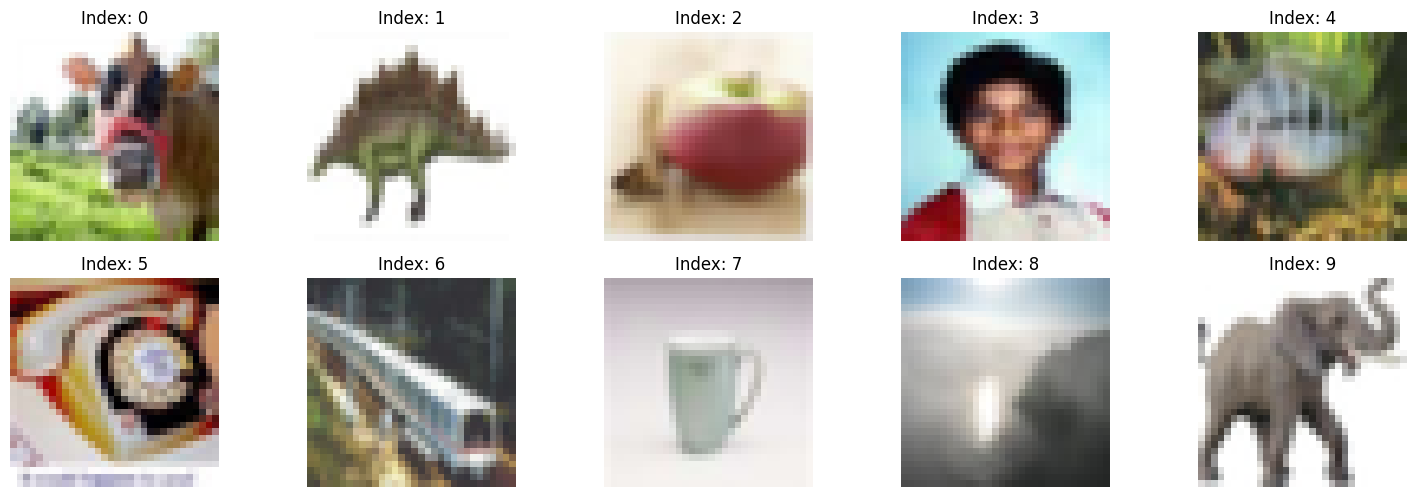

In [52]:
plt.figure(figsize=(15, 10))
for i in range(10):
    idx = indices[i]
    img = original_dataset.data[idx]
    
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Index: {idx}')

plt.tight_layout()
plt.show()

In [53]:
indices = max_10_indices_per_neuron[10]

plt.figure(figsize=(15, 4))  # Adjusted figure size for 10 images
for i, idx in enumerate(indices):
    if transposed[0][idx] == 0:
        print('skipped idx', idx)
        continue

    img = train_dataset.data[idx]
    
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Index: {idx}')

plt.tight_layout()
plt.show()

skipped idx tensor(0)
skipped idx tensor(1)
skipped idx tensor(2)
skipped idx tensor(3)
skipped idx tensor(4)
skipped idx tensor(5)
skipped idx tensor(6)
skipped idx tensor(7)
skipped idx tensor(8)
skipped idx tensor(9)


<Figure size 1500x400 with 0 Axes>

In [54]:
def plot_indices(indices):
    plt.figure(figsize=(15, 4))  # Adjusted figure size for 10 images
    
    for i, idx in enumerate(indices):
        img = train_dataset.data[idx]
        
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Index: {idx}')

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(max_10_indices_per_neuron)):
    indices = max_10_indices_per_neuron[i]
    plot_indices(indices)

#### Saving images to a file

In [56]:
def plot_indices_save(indices, filename, neuron_idx):
    plt.figure(figsize=(15, 4))  # Adjusted figure size for 10 images
    count = 0
    for i, idx in enumerate(indices):
        if transposed[neuron_idx][idx] == 0:
            print('skipped idx', idx)
            continue
        count += 1

        img = train_dataset.data[idx]
        
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Index: {idx}')

    if plt.gca().has_data():
        plt.tight_layout()
        plt.savefig(f'docs/neuron_CIFAR100/{count}_{filename}')  # Save the figure to a file
    plt.close()  # Close the figure to free memory

In [ ]:
from tqdm import tqdm

all_plots_filename = 'docs/all_neuron_plots.png'
plt.figure(figsize=(15, 4 * len(max_10_indices_per_neuron)))  # Adjust height based on number of neurons

for i in tqdm(range(len(max_10_indices_per_neuron)), desc="Plotting neurons"):
    indices = max_10_indices_per_neuron[i]
    plt.subplot(len(max_10_indices_per_neuron), 1, i + 1)  # One row per neuron
    plot_indices_save(indices, f'neuron_{i}_plots.png', i)  # Save individual plots if needed

plt.savefig(all_plots_filename)  # Save the combined figure
plt.close()  # Close the figure to free memory

# SAE Train Function

In [35]:
def train_sae(train_activations, selected_layer_config=fc1_config, epochs=30):
    # Use the selected layer configuration
    input_dim = selected_layer_config.input_dim
    hidden_dim = 2304
    sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)

    # Optimizer
    optimizer_sae = optim.Adam(sae.parameters(), lr=learning_rate)

    # Split the activations into train and test sets (80% train, 20% test)
    train_activations, test_activations = train_test_split(train_activations, test_size=0.2, random_state=42)

    # DataLoader for activations
    train_activations_loader = DataLoader(train_activations, batch_size=batch_size, shuffle=True)
    test_activations_loader = DataLoader(test_activations, batch_size=batch_size, shuffle=False)

    SAE_test_activations = test_activations #* Test dataset for SAE class

    # Training Loop for SAE
    for epoch in range(epochs):
        sae.train()
        total_loss = 0
        for batch in train_activations_loader:
            optimizer_sae.zero_grad()  # Zero out previous gradients

            # Forward pass through the SAE
            encoded, decoded = sae(batch)

            # Compute loss (MSE + sparsity penalty)
            loss = sae.compute_loss(batch, decoded, encoded)

            loss.backward()  # Backprop for SAE
            optimizer_sae.step()  # Optimizer step

            total_loss += loss.item()

        print(f"SAE Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_activations_loader):.4f}")
    
    sae.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_activations_loader:
            # Forward pass through the SAE
            encoded, decoded = sae(batch)

            # Compute loss (MSE + sparsity penalty)
            loss = sae.compute_loss(batch, decoded, encoded)

            total_test_loss += loss.item()

    print(f"SAE Test Loss: {total_test_loss/len(test_activations_loader):.4f}")

    return sae, test_activations_loader

In [33]:
colored_model_acts = model.get_cached_activations(fc1_config.name)
colored_model_acts.shape

torch.Size([10000, 256])

In [40]:
# Evaluation Loop for SAE
def cache_sae_acts(sae, test_activations_loader):
    sae.clear_cache()
    sae.eval()
    with torch.no_grad():
        for batch in test_activations_loader:
            # Forward pass through the SAE
            encoded, decoded = sae(batch, cache_activations=True)
    
    return sae.get_cached_activations('encoder')

In [43]:
sae, test_activations_loader = train_sae(colored_model_acts)
sae_activations = cache_sae_acts(sae, test_activations_loader)
sae_activations.shape

NameError: name 'cache_sae_acts' is not defined

In [42]:
meta_sae, _ = train_sae(sae_activations, selected_layer_config=encoder_config, epochs=5)

SAE Epoch [1/30], Loss: 0.0537
SAE Epoch [2/30], Loss: 0.0002
SAE Epoch [3/30], Loss: 0.0002
SAE Epoch [4/30], Loss: 0.0002
SAE Epoch [5/30], Loss: 0.0002
SAE Epoch [6/30], Loss: 0.0002
SAE Epoch [7/30], Loss: 0.0002
SAE Epoch [8/30], Loss: 0.0002
SAE Epoch [9/30], Loss: 0.0002
SAE Epoch [10/30], Loss: 0.0002
SAE Epoch [11/30], Loss: 0.0002
SAE Epoch [12/30], Loss: 0.0002
SAE Epoch [13/30], Loss: 0.0002
SAE Epoch [14/30], Loss: 0.0002
SAE Epoch [15/30], Loss: 0.0002
SAE Epoch [16/30], Loss: 0.0002
SAE Epoch [17/30], Loss: 0.0002
SAE Epoch [18/30], Loss: 0.0002
SAE Epoch [19/30], Loss: 0.0001
SAE Epoch [20/30], Loss: 0.0001
SAE Epoch [21/30], Loss: 0.0001
SAE Epoch [22/30], Loss: 0.0001
SAE Epoch [23/30], Loss: 0.0001
SAE Epoch [24/30], Loss: 0.0001
SAE Epoch [25/30], Loss: 0.0001
SAE Epoch [26/30], Loss: 0.0001
SAE Epoch [27/30], Loss: 0.0001
SAE Epoch [28/30], Loss: 0.0001
SAE Epoch [29/30], Loss: 0.0001
SAE Epoch [30/30], Loss: 0.0001
SAE Test Loss: 0.0002


In [44]:
torch.save(meta_sae.state_dict(), 'models/mnist_meta_sae_colored.pth')